# Plant Identification using Tensorflow

For this project, we will create a sequential model for detecting plant species and the status of the plant

The project is broken down into multiple steps:

* Creating a feature extractor using InceptionV3
* Using the extracted features to create a model for classifying the images into their respected classes

##**Machine Learning  model using Tensorflow with Keras**

We designed algorithms and models to recognize species and diseases in the crop leaves by using Convolutional Neural Network


### **Importing  the Librairies**

In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.4'


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras import optimizers

### Load the data
For this study we would download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ([PlantVillage Dataset](https://storage.googleapis.com/plantdata/PlantVillage.tar)). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

Input data is resized to 229x229 pixels to be given as input to the InceptionV3 neural network.



In [ ]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)


In [ ]:
!gdown https://drive.google.com/uc?id=1Bhh3VeMBH6F7vKqHdDDmdyi-7RfvQNqJ
!tar -xvf PlantVillage.tar.gz

### Prepare training and validation  dataset
Create the training and validation directories 

In [ ]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /root/.keras/datasets/PlantVillage/train : 43444files
total images for validation : /root/.keras/datasets/PlantVillage/validation : 10861files


### Label mapping

`categories.json` is used to map the labels to the images using the `json` model. 

In [ ]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
5efb5883fd88972332481e2c440cf3352bfa7310
replace Plant-Diseases-Detector-master/Plant_Diseases_Detector.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Plant-Diseases-Detector-master/Plant_Diseases_Detector.ipynb  
 extracting: Plant-Diseases-Detector-master/README.md  
  inflating: Plant-Diseases-Detector-master/_config.yml  
  inflating: Plant-Diseases-Detector-master/assets/Diseases classifier.jpeg  
  inflating: Plant-Diseases-Detector-master/assets/PlantVillagefarmer.jpg  
  inflating: Plant-Diseases-Detector-master/assets/detect_crop_disease_in_africa.png  
  inflating: Plant-Diseases-Detector-master/categories.json  


In [ ]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
print('Number of classes:',len(classes))

Number of classes: 38


###Select the InceptionV3 to use

In [ ]:
module_selection = ("inception_v3", 299, 2048)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                19494     
Total params: 22,871,366
Trainable params: 1,068,582
Non-trainable params: 21,802,784
_________________________________________________________________


### Specify Loss Function and Optimizer

In [ ]:
#Compile model specifying the optimizer learning rate
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=0.001), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model
train model using validation dataset for validate each steps

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/10


W0704 17:22:46.273658 139649001609088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


678/678 [==============================] - 473s 698ms/step - loss: 0.7405 - accuracy: 0.6792 - val_loss: 0.2846 - val_accuracy: 0.9109
Epoch 2/10
678/678 [==============================] - 471s 694ms/step - loss: 0.4340 - accuracy: 0.8549 - val_loss: 0.2770 - val_accuracy: 0.9059
Epoch 3/10
678/678 [==============================] - 470s 693ms/step - loss: 0.3925 - accuracy: 0.8738 - val_loss: 0.2341 - val_accuracy: 0.9228
Epoch 4/10
678/678 [==============================] - 471s 695ms/step - loss: 0.3679 - accuracy: 0.8751 - val_loss: 0.2158 - val_accuracy: 0.9350
Epoch 5/10
678/678 [==============================] - 470s 693ms/step - loss: 0.3502 - accuracy: 0.8832 - val_loss: 0.2254 - val_accuracy: 0.9274
Epoch 6/10
678/678 [==============================] - 470s 693ms/step - loss: 0.3400 - accuracy: 0.8874 - val_loss: 0.2024 - val_accuracy: 0.9352
Epoch 7/10
678/678 [==============================] - 472s 696ms/step - loss: 0.3274 - accuracy: 0.8959 - val_loss: 0.1919 - val_accura

###Check Performance
Plot training and validation accuracy and loss

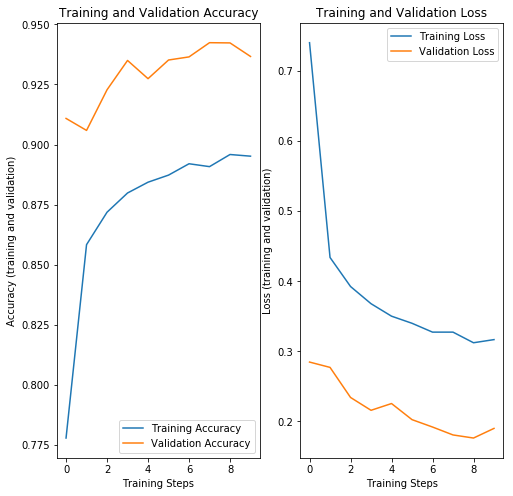

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test
Random sample images from validation dataset and predict

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/13046b34-7d6d-4fc1-a48c-e0bffc8921a3___YLCV_GCREC 2942.JPG
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.924948


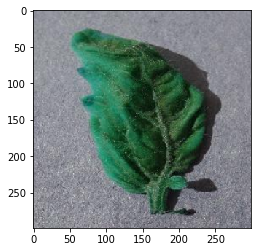

<Figure size 432x288 with 0 Axes>

SOURCE: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), file: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/57f4032d-d8f1-42e9-b133-c4b07f3dedcc___FAM_L.Blight 1545.JPG
PREDICTED: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), confidence: 0.997871


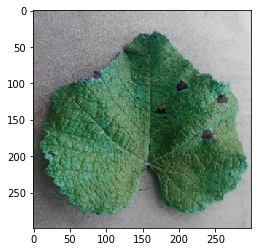

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/6a77132a-cbbd-4465-8cff-56bdcf55dd8d___YLCV_NREC 2173.JPG
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.284171


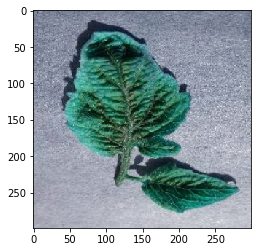

<Figure size 432x288 with 0 Axes>

SOURCE: class: Blueberry___healthy, file: Blueberry___healthy/06eacfab-fb39-40e0-bbce-927bc98fa2ac___RS_HL 2663.JPG
PREDICTED: class: Blueberry___healthy, confidence: 0.999727


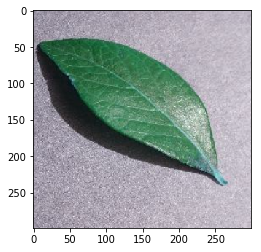

<Figure size 432x288 with 0 Axes>

SOURCE: class: Cherry_(including_sour)___Powdery_mildew, file: Cherry_(including_sour)___Powdery_mildew/d0632da1-03b6-43e5-9a31-0f24fe456428___FREC_Pwd.M 0536.JPG
PREDICTED: class: Cherry_(including_sour)___Powdery_mildew, confidence: 0.999782


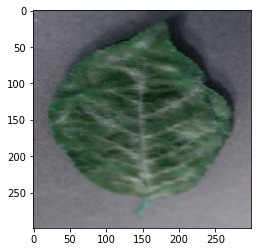

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

SOURCE: class: Tomato___healthy, file: Tomato___healthy/b65ccffe-a2fc-44d1-b56f-c8e97db5232e___RS_HL 0120.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.607259


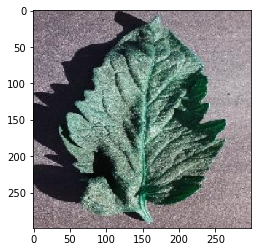

<Figure size 432x288 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/b4f30be3-8f14-4138-8b06-9beb44b20c62___RS_HL 3764.JPG
PREDICTED: class: Soybean___healthy, confidence: 0.988543


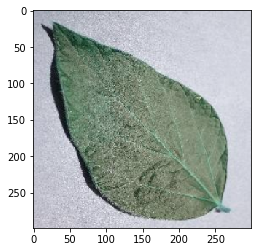

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

SOURCE: class: Tomato___Leaf_Mold, file: Tomato___Leaf_Mold/22cb45f2-6368-4e94-8deb-939d1f6b85ca___Crnl_L.Mold 7084.JPG
PREDICTED: class: Tomato___Leaf_Mold, confidence: 0.998060


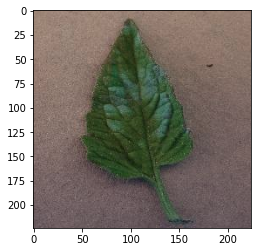

<Figure size 432x288 with 0 Axes>

SOURCE: class: Potato___Late_blight, file: Potato___Late_blight/2d736aa6-79a6-42b0-9e92-d859bcd72824___RS_LB 5244.JPG
PREDICTED: class: Potato___Late_blight, confidence: 0.999595


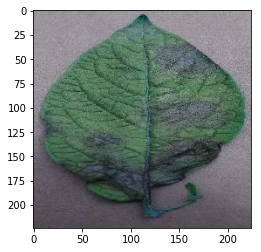

SOURCE: class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, file: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/348aafc3-4309-4507-b6b3-cb037711ca48___RS_GLSp 4399.JPG
PREDICTED: class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, confidence: 0.814200


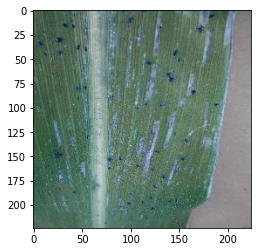

<Figure size 432x288 with 0 Axes>

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/4ada46ed-b31e-4b49-8a1b-70d449ad32d1___UF.Citrus_HLB_Lab 1006.JPG
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.988327


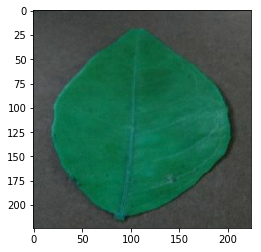

<Figure size 432x288 with 0 Axes>

SOURCE: class: Potato___Early_blight, file: Potato___Early_blight/4d1d5d85-e67d-4007-bceb-9b577f49065b___RS_Early.B 8885.JPG
PREDICTED: class: Pepper,_bell___Bacterial_spot, confidence: 0.971004


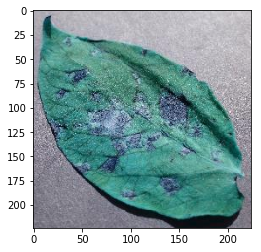

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## CONCLUSION
* The plant village dataset is used for training the model
* InceptionV3 is used for feature extraction
* Sequential mode build for classification
* We achive a training accuracy of 89.53% and validation accuracy of 93.67%